# Introduction
Author: Lazaros Gogos

AEM: 3877

This python notebook contains the usage of SVMs, given the task of classifying the imgaes of the CIFAR10 database.

---
Firstly, we take our already trained model, which is a convolutional one, and try to use hinge loss instead of crossentropy loss, to see whether we get similar results.

Then, we take the convolutional model, strip it of its output layer and use the second to last layer's results (predictions) to train an SVC for our images

Afterwards, we train an AutoEncoder with the images, take the hidden middle layer and train an SVM with its predictions, to see whether we can classify the images correctly (if the middle layer has the actual representations of the images stored in its weights)

Finally, we train a convolutional AutoEncoder to perform the same task, and see the results

Let's begin!

# Initial Code
Some imports and functions we will need.

In [1]:
# It's possible some of the following code snippets cannot be run.
# Run this cell to install the correct version of tensorflow, then do everything else
!pip install tensorflow==2.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling te

In [2]:
import numpy as np

import tensorflow as tf

from tensorflow import keras
from keras.utils import plot_model, to_categorical
from keras import layers, models
from keras.models import load_model

import matplotlib.pyplot as plt
import pickle
import random

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV


In [ ]:
import tensorflow as tf
tf.__version__
# version should be 2.14

'2.14.0'

In [3]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00
time: 503 µs (started: 2023-12-18 17:07:15 +00:00)


In [4]:
# necessary functions
def _plotModel(model_name, accuracy, val_accuracy, loss, val_loss):
  this_fig = plt.figure(figsize=(12,6))
  this_fig.suptitle('Performance of model: ' + model_name)

  # Plot the accuracy plot
  plt.subplot(1,2, 1)
  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label='val_accuracy', linestyle=':')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  plt.title('Classification Accuracy')
  plt.legend()
  plt.grid()

  plt.subplot(1,2, 2)
  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss', linestyle=':')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim(0,4)
  plt.legend()
  plt.title('Loss')

  plt.grid()
  plt.tight_layout()
  plt.show

def plotModel(model_name, history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  _plotModel(model_name, accuracy, val_accuracy, loss, val_loss)

# heatmap: https://qiita.com/bmj0114/items/8009f282c99b77780563
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
def plotSVCHeatmap(scores, C_range, gamma_range):
  """
  Scores must be of shape (C_range, gamma_range).
  """
  plt.figure(figsize=(8, 6))
  plt.subplots_adjust(left=.15, right=0.95, bottom=0.15, top=0.95)
  plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
  plt.xlabel('C')
  plt.ylabel('gamma')
  plt.colorbar()
  Cs = [f'2^{x}' for x in C_range]
  plt.xticks(np.arange(len(C_range)), Cs, rotation=45)

  gammas = [f'2^{x}' for x in gamma_range]
  plt.yticks(np.arange(len(gamma_range)), gammas)
  plt.title('Grid Search Scores')
  plt.show()

def plotLinearSVCAccuracy(scores, C_range):
  plt.figure(figsize=(8,6))
  plt.xlabel('C')
  plt.ylabel('mean score')
  Cs = [f'2^{x}' for x in C_range]
  plt.xticks(np.arange(len(C_range)), Cs, rotation=45)
  plt.plot(scores, label='Mean scores')
  plt.ylim(0, 1)
  plt.title('Scores of linear SVC')
  plt.legend()
  plt.show

time: 13.5 ms (started: 2023-12-18 17:07:16 +00:00)


In [5]:
# Define global variables
EPOCHS_MAX = 50
EPOCHS = 25
EPOCHS_MID = 20
EPOCHS_LESS = 10
SEED = 199
SAMPLES = 10000

# this prefix is needed when loading and saving models
prefix = '/content/drive/My Drive/keras_models_SVMs/'
!mkdir -p "$prefix"

time: 133 ms (started: 2023-12-18 17:07:16 +00:00)


In [6]:
# Load the data from the datasets of keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step
time: 22.9 s (started: 2023-12-18 17:07:16 +00:00)


In [7]:
# define the input shape
input_shape = x_train.shape[1:]

# Normalize the data to values in [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape targets to one dimensional shaped lists like so:
# (row,) instead of (row,1)
y_train, y_test = y_train.reshape(-1,), y_test.reshape(-1,)

# Documentation found at https://keras.io/api/models/

time: 1.83 s (started: 2023-12-18 17:07:39 +00:00)


In [8]:
# Take 10000 independent samples

np.random.seed(SEED) # for reproducible results

indices_train = np.random.randint(len(x_train), size=SAMPLES)
indices_test = np.random.randint(len(x_test), size=SAMPLES)

sampled_x_train = x_train[indices_train, :]
sampled_y_train = y_train[indices_train]
sampled_x_test = x_test[indices_test, :]
sampled_y_test = y_test[indices_test]

x_train_flat = x_train.reshape(-1, 3072)
x_test_flat = x_test.reshape(-1, 3072)


time: 2.51 s (started: 2023-12-18 17:07:41 +00:00)


In [9]:
def do_grid_search(param_grid, repr, test_repr, y_train, y_test):
  # perform grid search
  grid = GridSearchCV(SVC(verbose=2), n_jobs=-1, param_grid=param_grid, verbose=4)
  grid.fit(repr, y_train)
  grid.score(test_repr, y_test)
  print(f'The best accuracy was {grid.best_score_} for the parameters: {grid.best_params_}')
  return grid

time: 953 µs (started: 2023-12-18 17:07:43 +00:00)


In [10]:
def do_grid_search_linearsvc(param_grid, repr, test_repr, y_train, y_test):
  # perform grid search
  grid = GridSearchCV(LinearSVC(), n_jobs=-1, param_grid=param_grid)
  grid.fit(repr, y_train)
  grid.score(test_repr, y_test)
  print(f'The best accuracy was {grid.best_score_} for the parameters: {grid.best_params_}')
  return grid

time: 4.62 ms (started: 2023-12-18 17:07:43 +00:00)


# Would hinge loss work?

In [15]:
def make_and_train_model(model_name):
  # Create the model's architecture
  model = models.Sequential(name=model_name)

  # Convolutional layers
  model.add(layers.Conv2D(32, (3,3), activation='relu',
                          input_shape=input_shape, name='3x3__32_filters',))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', name='3x3__32_filters__2',))
  model.add(layers.MaxPooling2D((2, 2), name='2x2'))
  model.add(layers.Dropout(0.25, name='0.25')) # The dropout layer!

  # Copy of the above layer
  model.add(layers.Conv2D(32, (3,3), activation='relu',
                          input_shape=input_shape, name='3x3__32_filters__3',))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', name='3x3__32_filters__4',))
  model.add(layers.MaxPooling2D((2, 2), name='2x2__2'))
  model.add(layers.Dropout(0.3, name='0.30')) # The dropout layer!


  # Now add a dense layer
  model.add(layers.Flatten()) # but first, flatten!

  # Let's use 64 neurons
  model.add(layers.Dense(64, activation='relu', name='64neurons',))
  model.add(layers.Dropout(0.5, name='0.50')) # This is quite deep in the NN
  # hence a large number (0.5) might be preferable indeed

  # output
  model.add(layers.Dense(10, activation='linear', name='10neurons'))

  # Print model summary
  model.summary()

  # compile the model
  model.compile(optimizer = 'adam',
                loss = 'hinge',
                metrics = ['accuracy'])

  # To speed things up a little, let's alter the batch size
  batch_size = 128
  labels_train = to_categorical(y_train)
  labels_test = to_categorical(y_test)
  history = model.fit(x_train, labels_train, epochs=EPOCHS_MID, verbose=2,
                      batch_size=batch_size,
                      validation_data=(x_test, labels_test))
  return (model, history)

time: 2.67 ms (started: 2023-12-18 18:09:15 +00:00)


Model: "cnn_hinge_loss"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3x3__32_filters (Conv2D)    (None, 30, 30, 32)        896       
                                                                 
 3x3__32_filters__2 (Conv2D  (None, 28, 28, 32)        9248      
 )                                                               
                                                                 
 2x2 (MaxPooling2D)          (None, 14, 14, 32)        0         
                                                                 
 0.25 (Dropout)              (None, 14, 14, 32)        0         
                                                                 
 3x3__32_filters__3 (Conv2D  (None, 12, 12, 32)        9248      
 )                                                               
                                                                 
 3x3__32_filters__4 (Conv2D  (None, 10, 10, 32)     

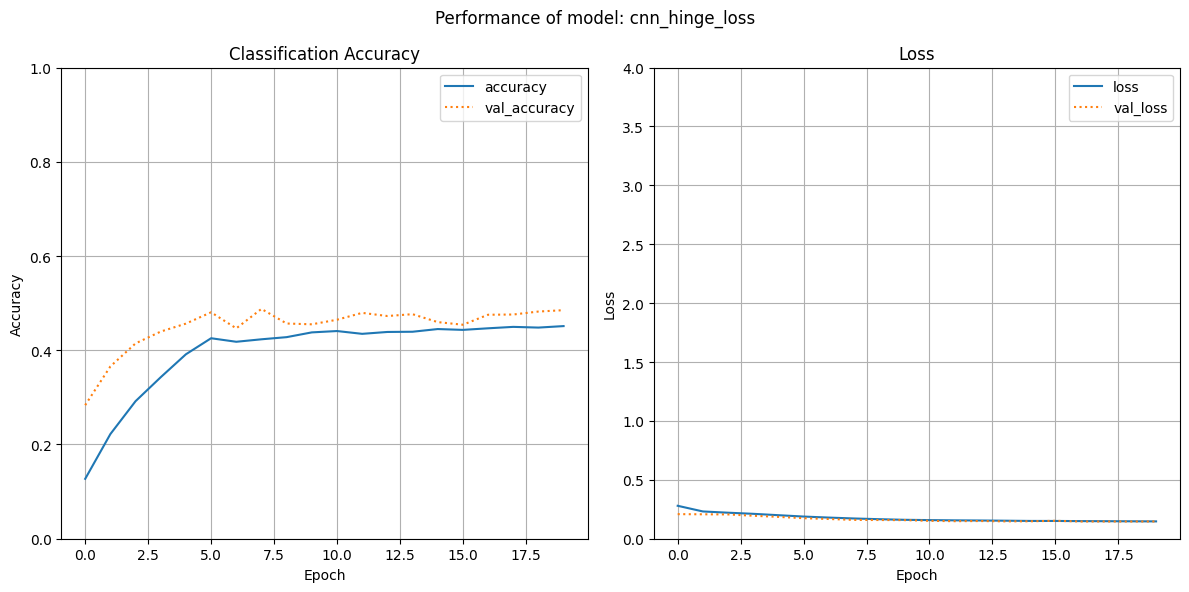

In [16]:
# %%script false --no-raise-error
cnn_name = 'cnn_hinge_loss'
model, history = make_and_train_model(cnn_name)
plotModel(model_name=cnn_name, history=history)
model.save(prefix+cnn_name+'.keras')

In [20]:
evaluation = model.evaluate(x_test, to_categorical(y_test))
print(f'The model\'s score is {evaluation[1]} and its loss is {evaluation[0]}')

313/313 [==============================] - 8s 26ms/step - loss: 0.1466 - accuracy: 0.4851
The model's score is 0.48510000109672546 and its loss is 0.14661602675914764
time: 11.6 s (started: 2023-12-18 18:59:09 +00:00)


# Use an SVC on a previously trained CNN model
This time, let's use the second to last layer to train an SVC to see how it performs. First, we will create a Convolutional Neural Network and train it with our images.

In [ ]:
# Grab the already trained model from the previous project
cnn = load_model(prefix+'cnn.keras')
cnn.summary()

Model: "Surpassed128CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 3x3__32_filters (Conv2D)    (None, 30, 30, 32)        896       
                                                                 
 3x3__32_filters__2 (Conv2D  (None, 28, 28, 32)        9248      
 )                                                               
                                                                 
 2x2 (MaxPooling2D)          (None, 14, 14, 32)        0         
                                                                 
 0.25 (Dropout)              (None, 14, 14, 32)        0         
                                                                 
 3x3__32_filters__3 (Conv2D  (None, 12, 12, 32)        9248      
 )                                                               
                                                                 
 3x3__32_filters__4 (Conv2D  (None, 10, 10, 32)    

In [ ]:
# Let's get the appropriate layers
hidden = keras.Model(inputs=cnn.inputs, outputs=cnn.layers[-2].output)

time: 25.2 ms (started: 2023-12-15 16:02:02 +00:00)


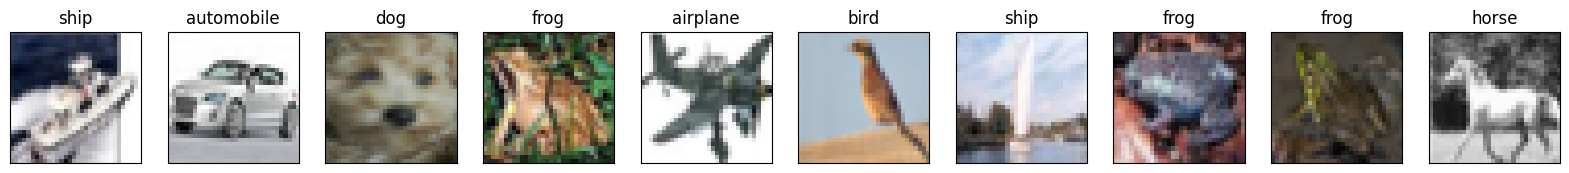

time: 853 ms (started: 2023-12-15 16:02:07 +00:00)


In [ ]:
label_names = {0:'airplane',
               1:'automobile',
               2:'bird',
               3:'cat',
               4:'deer',
               5:'dog',
               6:'frog',
               7:'horse',
               8:'ship',
               9:'truck'}

def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices]

    plt.figure(figsize=(20, 4))
    for i, (image1) in enumerate(images1):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(image1.reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title(label_names[images2[i]])
        # ax = plt.subplot(2, n, i + 1 + n)
        # plt.imshow(image2.reshape(32, 32, 3))
        # plt.gray()
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)

    plt.show()

display(sampled_x_train, sampled_y_train)

Now that we have the internal representations, try to fit an SVC with a grid search approach to find the best hyper-parameters

In [ ]:
# Get the outputs/representations of the intermediate layer
representations = hidden.predict(sampled_x_train)
test_representations = hidden.predict(sampled_x_test)

313/313 [==============================] - 7s 21ms/step
time: 21.7 s (started: 2023-12-15 16:02:10 +00:00)


In [ ]:
C_range = range(-7, 15, 2)
gamma_range = range(-15, 4, 2)
param_grid = {'kernel': ['rbf'],
                'C' : [2 ** x for x in C_range],
                'gamma': [2 ** x for x in gamma_range]
                }

grid = do_grid_search(param_grid, representations, test_representations,
                      sampled_y_train, sampled_y_test)
with open(prefix+'goodGrid.svc', 'wb') as fo:
  pickle.dump(grid, fo)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
[LibSVM]The best accuracy was 0.7676000000000001 for the parameters: {'C': 2, 'gamma': 0.125, 'kernel': 'rbf'}
time: 1h 32min 15s (started: 2023-12-10 15:09:22 +00:00)


Let's do a finer grid search now, around the parameters we just found.

In [21]:
if False:
  with open(prefix+'goodGrid.svc', 'rb') as fo:
    grid = pickle.load(fo)

time: 758 ms (started: 2023-12-18 19:27:36 +00:00)


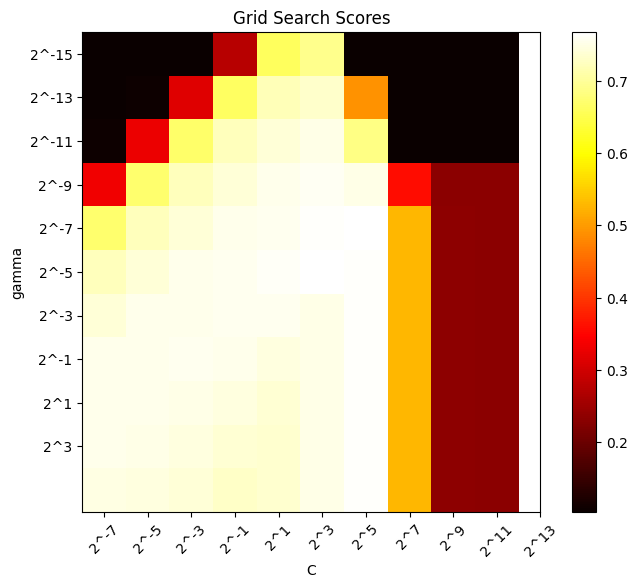

time: 410 ms (started: 2023-12-18 19:27:48 +00:00)


In [22]:
C_range = range(-7, 15, 2)
gamma_range = range(-15, 4, 2)
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
plotSVCHeatmap(scores, C_range, gamma_range)

In [ ]:
scores

array([[0.1035, 0.1035, 0.1048, 0.2767, 0.6609, 0.6907, 0.1036, 0.1035,
        0.1035, 0.1035],
       [0.1035, 0.1065, 0.3159, 0.6635, 0.72  , 0.7333, 0.4916, 0.1035,
        0.1035, 0.1035],
       [0.1069, 0.3289, 0.6678, 0.7225, 0.7409, 0.7507, 0.6861, 0.1035,
        0.1035, 0.1035],
       [0.3318, 0.6695, 0.7224, 0.7413, 0.7539, 0.7587, 0.752 , 0.3587,
        0.2321, 0.2315],
       [0.6706, 0.7228, 0.7407, 0.754 , 0.756 , 0.7641, 0.7676, 0.5272,
        0.2339, 0.2323],
       [0.7231, 0.7411, 0.7528, 0.7549, 0.7605, 0.7651, 0.7639, 0.5273,
        0.2339, 0.2323],
       [0.7412, 0.7526, 0.7546, 0.7563, 0.7563, 0.7506, 0.7637, 0.5273,
        0.2339, 0.2323],
       [0.7525, 0.7545, 0.755 , 0.7537, 0.7455, 0.7498, 0.7637, 0.5273,
        0.2339, 0.2323],
       [0.7543, 0.7532, 0.7503, 0.7467, 0.7369, 0.7498, 0.7637, 0.5273,
        0.2339, 0.2323],
       [0.7521, 0.7498, 0.7465, 0.7368, 0.7359, 0.7498, 0.7637, 0.5273,
        0.2339, 0.2323],
       [0.7487, 0.7447, 0.7402

time: 6.88 ms (started: 2023-12-11 07:00:44 +00:00)


In [ ]:
prev_params = grid.best_params_
C = np.log2(prev_params['C'])
gamma = np.log2(prev_params['gamma'])
# C = 1
# gamma = -3
C_finer_range = np.arange(C-2, C+2, .25)
gamma_finer_range = np.arange(gamma-2, gamma+2, .25)
param_grid = {'kernel': ['rbf'],
              'C': [2 ** x for x in C_finer_range],
              'gamma': [2 ** x for x in gamma_finer_range]
             }
finer_grid = do_grid_search(param_grid, representations, test_representations,
                      sampled_y_train, sampled_y_test)
with open(prefix+'finerGrid.svc', 'wb') as fo:
  pickle.dump(finer_grid, fo)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[LibSVM]The best accuracy was 0.7690999999999999 for the parameters: {'C': 2.378414230005442, 'gamma': 0.08838834764831845, 'kernel': 'rbf'}
time: 3h 8min 21s (started: 2023-12-11 07:07:52 +00:00)


In [23]:
# reload data from disk?
if False:
  with open(prefix+'finerGrid.svc', 'rb') as fo:
    finer_grid = pickle.load(fo)
    C = 1
    gamma = -3
    C_finer_range = np.arange(C-2, C+2, .25)
    gamma_finer_range = np.arange(gamma-2, gamma+2, .25)

time: 794 ms (started: 2023-12-18 19:31:58 +00:00)


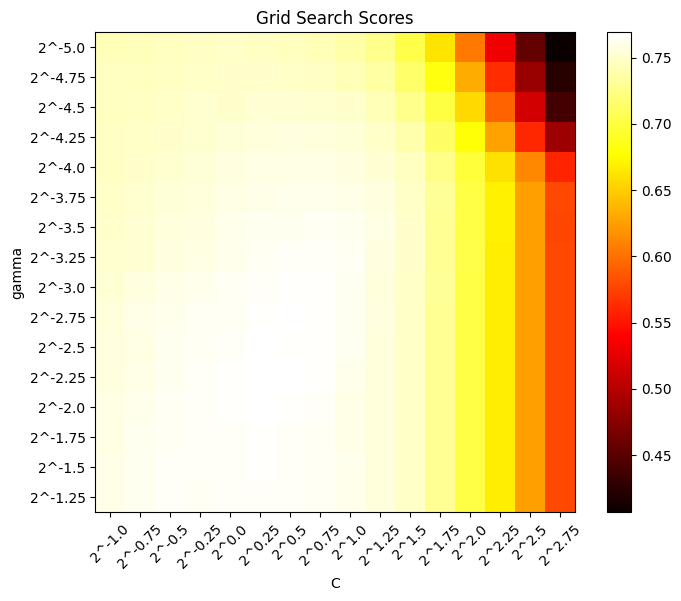

time: 637 ms (started: 2023-12-18 19:32:13 +00:00)


In [24]:
finer_scores = finer_grid.cv_results_['mean_test_score'].reshape(len(C_finer_range), len(gamma_finer_range))
plotSVCHeatmap(finer_scores, C_finer_range, gamma_finer_range)

# scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
# plotSVCHeatmap(scores, C_range, gamma_range)

We've found the best combination of `C,γ`, let's train our model for the whole dataset and see how good the accuracy can get!

In [ ]:
# prev_params = finer_grid.best_params_
# C = np.log2(prev_params['C'])
# gamma = np.log2(prev_params['gamma'])

C = 2** 1.25
gamma = 2** -3.5
repr_train = hidden.predict(x_train)
repr_test = hidden.predict(x_test)

313/313 [==============================] - 5s 17ms/step
time: 1min 36s (started: 2023-12-15 16:20:55 +00:00)


In [ ]:
# Train an SVC with One Versus Rest approach
svc_OVR = SVC(C=C, gamma=gamma, kernel='rbf', verbose=True, decision_function_shape='ovr')
svc_OVR.fit(repr_train, y_train)
score_OVR = svc_OVR.score(repr_test, y_test)
print(f'The score with one-versus-all is: {score_OVR}\nThe number of support vectors per class:{svc_OVR.n_support_}')

if True:
  with open(prefix+'completeSVC_OVR.svc', 'wb') as fo:
    pickle.dump(svc_OVR, fo)

[LibSVM]The score with one-versus-all is: 0.7358
The number of support vectors per class:[3138 2522 3830 4408 3492 3976 2691 3012 2254 2485]
time: 5min 41s (started: 2023-12-11 20:40:20 +00:00)


In [ ]:
# Train an SVC with One Versus One strategy
svc_OVO = SVC(C=C, gamma=gamma, kernel='rbf', verbose=True, decision_function_shape='ovo')
svc_OVO.fit(repr_train, y_train)
score_OVO = svc_OVO.score(repr_test, y_test)
print(f'The score with one-versus-one is: {score_OVO}\nThe number of support vectors per class:{svc_OVO.n_support_}')

if True:
  with open(prefix+'completeSVC_OVO.svc', 'wb') as fo:
    pickle.dump(svc_OVO, fo)

[LibSVM]The score with one-versus-one is: 0.7358
The number of support vectors per class:[3138 2522 3830 4408 3492 3976 2691 3012 2254 2485]
time: 4min 51s (started: 2023-12-11 20:46:01 +00:00)


# LinearSVC on pre-trained CNN
The accuracy we got with an SVC using an RBF kernel was 73.58% for our test set.

Let's try a different approach, by utilizing a linear kernel instead of the RBF kernel. Why would we want to do this?

The reason is simple. A linear SVC converges faster when the number of samples is a lot bigger than the amount of features. In our case, the number of features is 3072, whereas the actual amount of samples is 50000. This is only true if we solve the primal problem (n_samples > n_features).

Later on we will also test what happens if n_samples < n_features, and we'll solve the problem in its dual form.

In [ ]:
C_range = range(-12, 12)
linear_param_grid = {'C': [2 ** x for x in C_range],
                    #  'intercept_scaling': [5],
                     'fit_intercept': [True],
                    #  'loss': ['hinge'],
                     'dual':[False], # false because n_samples >> n_features
                     'verbose': [3]}

linear_grid = do_grid_search_linearsvc(linear_param_grid, representations, test_representations,
                                       sampled_y_train, sampled_y_test)

[LibLinear]The best accuracy was 0.7401 for the parameters: {'C': 0.0625, 'dual': False, 'fit_intercept': True, 'verbose': 3}
time: 3min 13s (started: 2023-12-15 16:04:48 +00:00)


How did it do?

[0.7273 0.7335 0.737  0.7385 0.7391 0.7391 0.7381 0.7385 0.7401 0.7393
 0.739  0.7376 0.7376 0.7367 0.7368 0.7369 0.7369 0.7369 0.737  0.7366
 0.7367 0.7366 0.7365 0.7367]


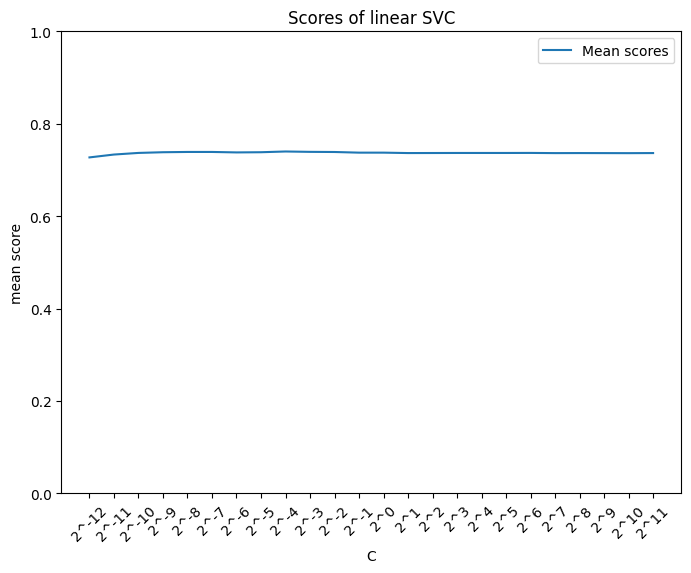

time: 625 ms (started: 2023-12-15 16:08:02 +00:00)


In [ ]:
scores = linear_grid.cv_results_['mean_test_score']
print(scores)
plotLinearSVCAccuracy(scores, C_range)

In [ ]:
best_C = -4
C_range = np.arange(best_C-2, best_C+2, .25)
finer_linear_param_grid = {'C': [2 ** x for x in C_range],
                    #  'intercept_scaling': [5],
                     'fit_intercept': [True],
                    #  'loss': ['hinge'],
                     'dual':[False], # false because n_samples >> n_features
                     'verbose': [3]}

finer_linear_grid = do_grid_search_linearsvc(finer_linear_param_grid, representations, test_representations,
                                       sampled_y_train, sampled_y_test)

[LibLinear]The best accuracy was 0.7401 for the parameters: {'C': 0.0625, 'dual': False, 'fit_intercept': True, 'verbose': 3}
time: 1min 5s (started: 2023-12-15 16:11:42 +00:00)


[0.7381 0.738  0.7381 0.738  0.7385 0.7392 0.7397 0.7397 0.7401 0.7393
 0.7393 0.7387 0.7393 0.7389 0.7389 0.7389]


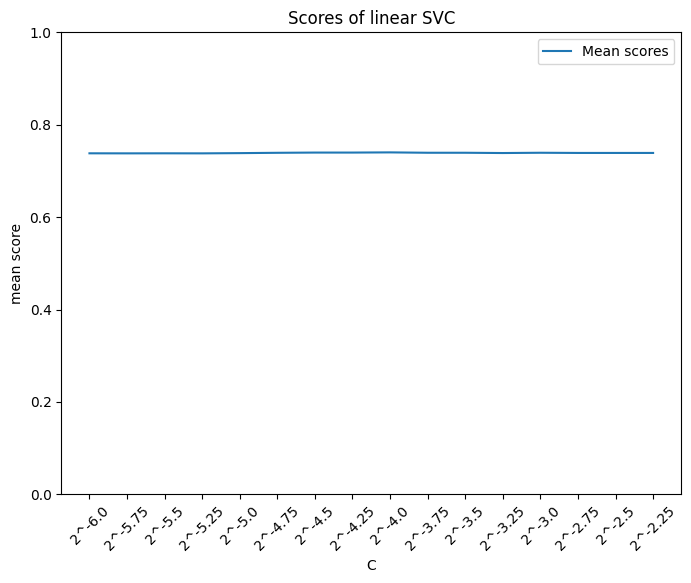

time: 355 ms (started: 2023-12-15 16:12:47 +00:00)


In [ ]:
scores = finer_linear_grid.cv_results_['mean_test_score']
print(scores)
plotLinearSVCAccuracy(scores, C_range)

In [ ]:
est = finer_linear_grid.best_estimator_
# remember, repr_test is the variable holding the representations of the CNN model
# for the whole test set
est.score(repr_test, y_test)

0.7157

time: 19.2 ms (started: 2023-12-15 16:22:32 +00:00)


If we only had 1000 samples, would our classifier work?

In [ ]:
smaller_x_train = sampled_x_train[:1000]
smaller_y_train = sampled_y_train[:1000]
smaller_x_test = sampled_x_test[:1000]
smaller_y_test = sampled_y_test[:1000]

smaller_representations = hidden.predict(smaller_x_train)
smaller_test_representations = hidden.predict(smaller_x_test)

# do grid search for a linear SVC
dual_param_grid = {'C': [2**x for x in np.arange(-8, -5, .25)],
                   'dual': [True],
                   'loss': ['hinge'],
                   'verbose': [3],
                   'fit_intercept': [True],}
dual_svc = GridSearchCV(LinearSVC(), param_grid=dual_param_grid, n_jobs=-1)
# dual_svc.fit()
# linear_svc = LinearSVC(loss='hinge', dual=True, C=2)
dual_svc.fit(smaller_representations, smaller_y_train)
dual_svc.score(smaller_test_representations, smaller_y_test)
print(f'The best accuracy was {dual_svc.best_score_} when: {dual_svc.best_params_}')

32/32 [==============================] - 1s 17ms/step
[LibLinear]The best accuracy was 0.722 when: {'C': 0.015625, 'dual': True, 'fit_intercept': True, 'loss': 'hinge', 'verbose': 3}
time: 4.18 s (started: 2023-12-15 16:35:32 +00:00)


What are our findings?

Well, training an SVM for 10,000 samples (1/5 of the actual dataset) with an RBF kernel took 50 minutes of searching to find the best combination, and another 50 minutes to fine tune the parameters. The best accuracy was about 74% for `C=2^1.25` and `γ=2^-3.5`.

**But**, we can use a linear SVM for 10,000 samples, solve the primal problem because `n_samples > n_features` and approximate the accuracy of an RBF-kernel SVM. The best accuracy with the same amount of samples is 74% for C=2^-7

The stunning finding is that we can achieve similar results with only 1,000 samples! What this means is that, for a random smaller proportion of our data, we can hit 73% accuracy by having C=2^-6.25, solving the `dual` problem and having a `hinge` loss (not squared_hinge), while also fitting the intercept.

Below, we can see the linear SVC achieving 70% accuracy after being trained only for 1,000 samples! Incredible

In [ ]:
x_test_repr = hidden.predict(x_test)
dual_svc.score(x_test_repr, y_test)

313/313 [==============================] - 6s 18ms/step


0.6939

time: 11 s (started: 2023-12-15 16:36:07 +00:00)


# AutoEncoders and SVMs
So, what now? We can train a convolutional autoencoder with our images, take the intermediate layer and train an SVM with it. Will the classification be better? Will the intermediate layer learn the actual representations of the images?

Let's find out

In [ ]:
def displayReconstructions(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

time: 840 µs (started: 2023-12-16 12:12:49 +00:00)


In [ ]:
# AUTOENCODER - https://keras.io/examples/vision/autoencoder/
model_name = 'ConvolutionalAutoEncoder'
model = models.Sequential(name=model_name)

model.add(layers.Input(shape=(32, 32, 3)))

# downscale
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', name='e64'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', name='e128'))
model.add(layers.MaxPooling2D(2,2))


# Add middle layer
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', name='middle'))
model.add(layers.Dense(8*8*128)) # internal representation
model.add(layers.Reshape((8, 8, 128), name='reshaper'))

# start upscaling
model.add(layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2, name='d128'))
model.add(layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2, name='d64'))
model.add(layers.Conv2D(3, (3,3), activation='sigmoid', padding='same', name='OUT'))

model.summary()

Model: "ConvolutionalAutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 e64 (Conv2D)                (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 e128 (Conv2D)               (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 middle (Dense)              (None, 256)  

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

time: 15.1 ms (started: 2023-12-15 17:42:09 +00:00)


In [ ]:
history = model.fit(x_train, x_train, epochs=EPOCHS,
          verbose=2, validation_data=(x_test, x_test))

Epoch 1/25
1563/1563 - 580s - loss: 0.5812 - accuracy: 0.6545 - val_loss: 0.5695 - val_accuracy: 0.7320 - 580s/epoch - 371ms/step
Epoch 2/25
1563/1563 - 592s - loss: 0.5665 - accuracy: 0.7391 - val_loss: 0.5656 - val_accuracy: 0.7519 - 592s/epoch - 379ms/step
Epoch 3/25
1563/1563 - 581s - loss: 0.5642 - accuracy: 0.7530 - val_loss: 0.5647 - val_accuracy: 0.7544 - 581s/epoch - 372ms/step
Epoch 4/25
1563/1563 - 582s - loss: 0.5632 - accuracy: 0.7573 - val_loss: 0.5639 - val_accuracy: 0.7599 - 582s/epoch - 372ms/step
Epoch 5/25
1563/1563 - 557s - loss: 0.5625 - accuracy: 0.7587 - val_loss: 0.5631 - val_accuracy: 0.7551 - 557s/epoch - 356ms/step
Epoch 6/25
1563/1563 - 572s - loss: 0.5620 - accuracy: 0.7596 - val_loss: 0.5629 - val_accuracy: 0.7637 - 572s/epoch - 366ms/step
Epoch 7/25
1563/1563 - 580s - loss: 0.5617 - accuracy: 0.7602 - val_loss: 0.5644 - val_accuracy: 0.7518 - 580s/epoch - 371ms/step
Epoch 8/25
1563/1563 - 574s - loss: 0.5615 - accuracy: 0.7613 - val_loss: 0.5627 - val_acc

As we can see below, the autoencoder has how to reconstruct the images pretty well. The basic features have been encoded in the middle layer

313/313 [==============================] - 32s 103ms/step


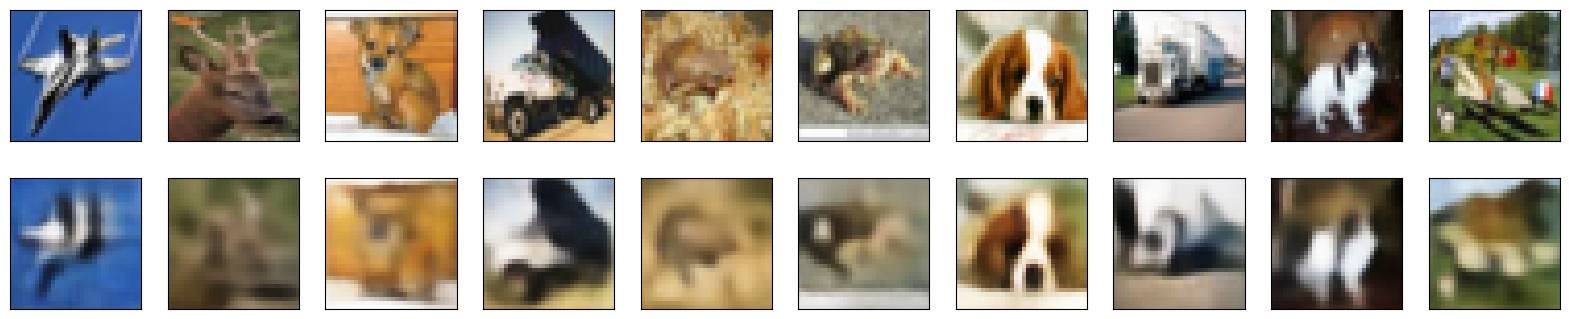

time: 36.2 s (started: 2023-12-15 21:42:41 +00:00)


In [ ]:
reconstructions = model.predict(x_test)
displayReconstructions(x_test, reconstructions)

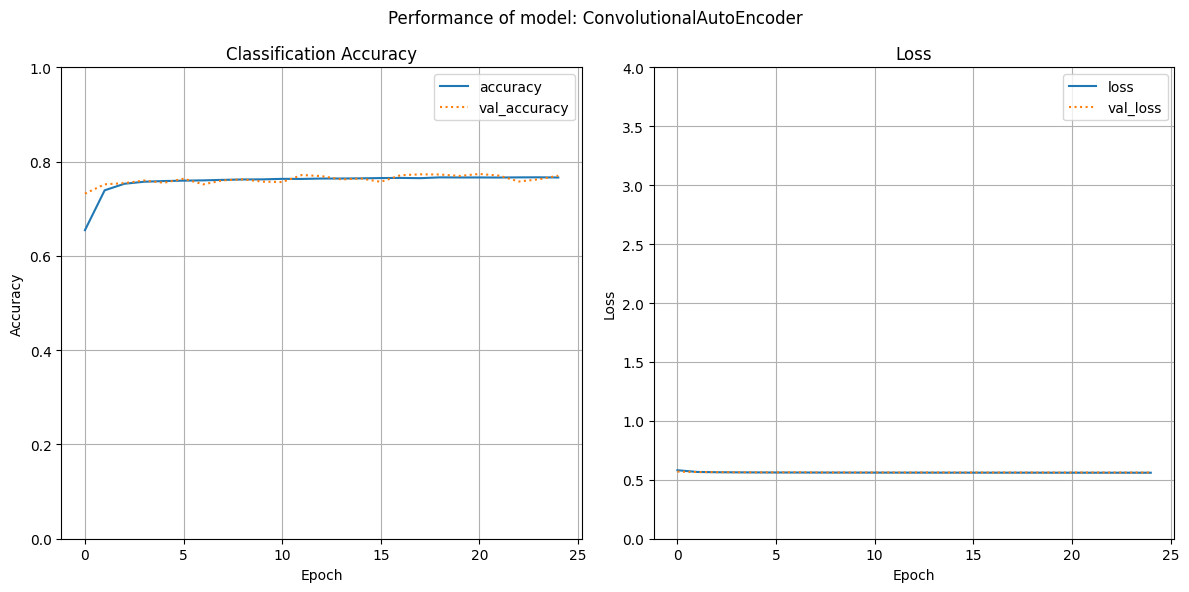

time: 997 ms (started: 2023-12-15 21:43:18 +00:00)


In [ ]:
plotModel(model_name, history)

In [ ]:
model.save(prefix+model_name+'.keras') # this keras model was saved with tf.__version__ = 2.14.0
autoencoder = model

Let's find out if we can use the hidden layer to train an SVM and classify images

In [ ]:
# load model from Drive?
if True:
  model_name = 'ConvolutionalAutoEncoder'
  autoencoder = load_model(prefix+model_name+'.keras')

time: 2.76 s (started: 2023-12-16 12:12:49 +00:00)


In [ ]:
# Extract middle layer
middle_layer = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('middle').output)

time: 7.3 ms (started: 2023-12-16 12:12:52 +00:00)


In [ ]:
repr = middle_layer.predict(sampled_x_train)
test_repr = middle_layer.predict(x_test)

313/313 [==============================] - 14s 44ms/step
time: 1min 3s (started: 2023-12-16 12:12:52 +00:00)


In [ ]:
C_range = range(-15, 15, 2)
linear_param_grid = {'C': [2 ** x for x in C_range],
                    #  'intercept_scaling': [5],
                     'fit_intercept': [True],
                    #  'loss': ['hinge'],
                     'dual':[False], # false because n_samples >> n_features
                     'verbose': [3]}
grid_auto_svm = do_grid_search_linearsvc(linear_param_grid, repr, test_repr,
                         sampled_y_train, y_test)

[LibLinear]The best accuracy was 0.3931 for the parameters: {'C': 0.0078125, 'dual': False, 'fit_intercept': True, 'verbose': 3}
time: 6min 38s (started: 2023-12-16 12:13:57 +00:00)


In [ ]:
if True: # save model?
  with open(prefix+'grid_auto_svm.svc','wb') as fo:
    pickle.dump(grid_auto_svm,fo)

if False: # load model?
  with open(prefix+'grid_auto_svm.svc','rb') as fo:
    grid_auto_svm = pickle.load(fo)

[0.3624 0.3862 0.3892 0.3901 0.3931 0.3926 0.391  0.3902 0.3906 0.3905
 0.3905 0.3905 0.3905 0.3903 0.3904]


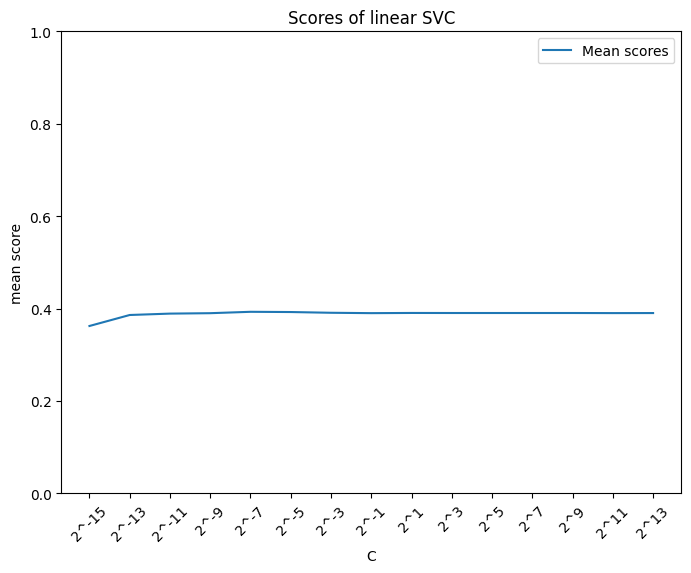

time: 441 ms (started: 2023-12-16 12:21:27 +00:00)


In [ ]:
C_range = range(-15, 15, 2)
scores = grid_auto_svm.cv_results_['mean_test_score']
print(scores)
plotLinearSVCAccuracy(scores, C_range)

We achieve an accuarcy of 39.31%. Not great. Let's try finding a better C close to `C=2^-7`

In [ ]:
C = np.log2(0.0078125) # = -7
C_range = np.arange(C-2, C+2, .25)
linear_param_grid = {'C': [2 ** x for x in C_range],
                    #  'intercept_scaling': [5],
                     'fit_intercept': [True],
                    #  'loss': ['hinge'],
                     'dual':[False], # false because n_samples >> n_features
                     'verbose': [3]}
grid_auto_svm_finer = do_grid_search_linearsvc(linear_param_grid, repr, test_repr,
                         sampled_y_train, y_test)

[LibLinear]The best accuracy was 0.39380000000000004 for the parameters: {'C': 0.004645340292979379, 'dual': False, 'fit_intercept': True, 'verbose': 3}
time: 4min 33s (started: 2023-12-16 13:08:26 +00:00)


[0.3901 0.3907 0.3915 0.3923 0.3931 0.3938 0.3937 0.3929 0.3931 0.3929
 0.3929 0.393  0.3929 0.3926 0.3927 0.3929]


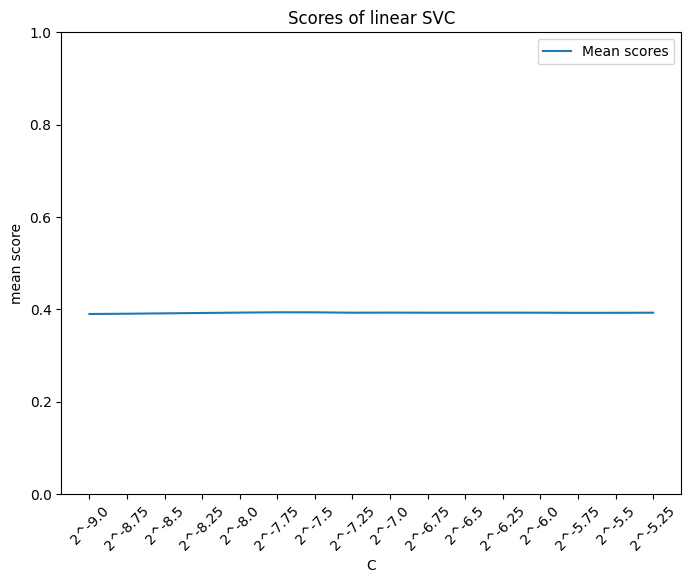

time: 341 ms (started: 2023-12-16 13:13:31 +00:00)


In [ ]:
scores = grid_auto_svm_finer.cv_results_['mean_test_score']
print(scores)
plotLinearSVCAccuracy(scores, C_range)

In [ ]:
def dual_linear_svc(param_grid, repr, test_repr, y_train, y_test):
  dual_svc = GridSearchCV(LinearSVC(), param_grid=dual_param_grid, n_jobs=-1)
  dual_svc.fit(repr, y_train)
  dual_svc.score(test_repr, y_test)
  print(f'The best accuracy was {dual_svc.best_score_} when: {dual_svc.best_params_}')
  return dual_svc

time: 1.01 ms (started: 2023-12-10 09:04:42 +00:00)


In [ ]:
# do grid search for a linear SVC
dual_param_grid = {'C': [2**x for x in range(-8, 5, 2)],
                   'dual': [True],
                   'loss': ['hinge'],
                   'verbose': [3],
                   'fit_intercept': [True],}
est = dual_linear_svc(dual_param_grid, repr, test_repr,
                      sampled_y_train, y_test)

[LibLinear]The best accuracy was 0.3586 when: {'C': 0.00390625, 'dual': True, 'fit_intercept': True, 'loss': 'hinge', 'verbose': 3}
time: 18min 32s (started: 2023-12-10 09:04:49 +00:00)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The linear SVC performed worse and could not converge. We hit an accuarcy of 35%, even less than the linear SVC that solved the problem in its primal form.

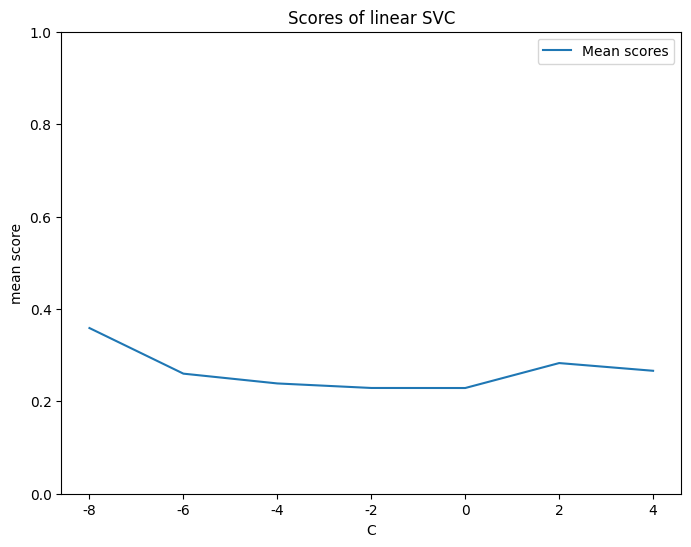

time: 296 ms (started: 2023-12-10 11:36:43 +00:00)


In [ ]:
scores = est.cv_results_['mean_test_score']
plotLinearSVCAccuracy(scores, range(-8, 5, 2))

# SVMs on raw image data
Let's try using SVMs on raw images, instead of the outputs of convolutional neural networks.

In [ ]:
C_range = range(-15, 13, 2)
gamma_range = range(-15, 13, 2)
param_grid = {'kernel': ['rbf'],
                'C' : [2 ** x for x in C_range],
                'gamma': [2 ** x for x in gamma_range]
                }
sampled_x_train_flat = sampled_x_train.reshape(-1, 3072)[:1000]
sampled_x_test_flat = sampled_x_test.reshape(-1, 3072)[:1000]

grid_raw = do_grid_search(param_grid, sampled_x_train_flat, sampled_x_test_flat,
                      sampled_y_train[:1000], sampled_y_test[:1000])
with open(prefix+'grid_raw_images.svc', 'wb') as fo:
  pickle.dump(grid_raw, fo)

Fitting 5 folds for each of 196 candidates, totalling 980 fits
[LibSVM]The best accuracy was 0.363 for the parameters: {'C': 2, 'gamma': 0.0078125, 'kernel': 'rbf'}
time: 33min 18s (started: 2023-12-14 23:48:33 +00:00)


In [ ]:
if False:
  with open(prefix+'grid_raw_images.svc', 'rb') as fo:
    grid_raw = pickle.load(fo)

Show a heatmap of the results.

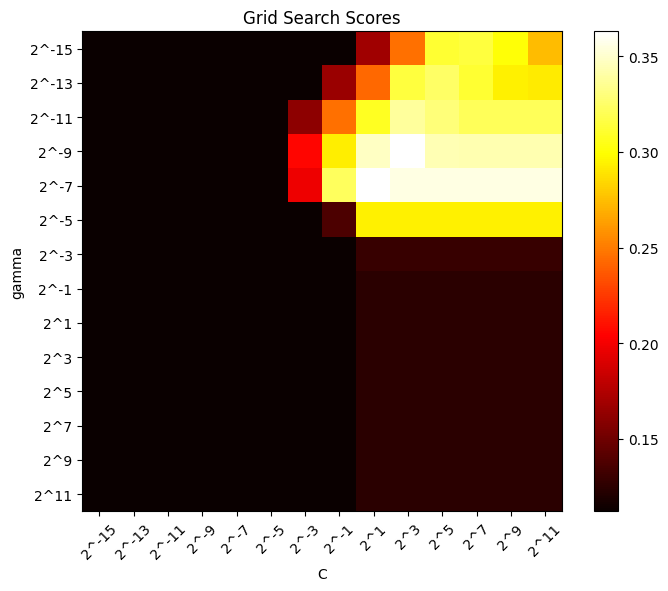

time: 384 ms (started: 2023-12-15 00:51:31 +00:00)


In [ ]:
# in the following reshape, we must call `.transpose()` because the reshaping is not done correctly by default
# due to the scores being a rectangular matrix, numpy doesn't know how to reshape correctly
scores = grid_raw.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range)).transpose()
plotSVCHeatmap(scores, C_range, gamma_range)

In [ ]:
scores

array([[0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.168,
        0.246, 0.312, 0.314, 0.301, 0.274],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.166, 0.243,
        0.314, 0.324, 0.312, 0.294, 0.292],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.162, 0.246, 0.308,
        0.338, 0.329, 0.321, 0.321, 0.321],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.206, 0.293, 0.348,
        0.363, 0.344, 0.343, 0.343, 0.343],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.198, 0.322, 0.363,
        0.356, 0.356, 0.356, 0.356, 0.356],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.137, 0.294,
        0.294, 0.294, 0.294, 0.294, 0.294],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.129,
        0.129, 0.129, 0.129, 0.129, 0.129],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.124,
        0.124, 0.124, 0.124, 0.124, 0.124],
       [0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.124,
        0

time: 8.81 ms (started: 2023-12-15 00:51:34 +00:00)


Let's now do a finer grid search to find the best parameters `C`, `γ`.

In [ ]:
prev_params = grid_raw.best_params_
C = np.log2(prev_params['C'])
gamma = np.log2(prev_params['gamma'])
# print(C, gamma)
# C = 1
# gamma = -7
C_finer_range = np.arange(C-2, C+2, .25)
gamma_finer_range = np.arange(gamma-2, gamma+2, .25)
param_grid = {'kernel': ['rbf'],
              'C': [2 ** x for x in C_finer_range],
              'gamma': [2 ** x for x in gamma_finer_range]
             }

sampled_x_train_flat = sampled_x_train.reshape(-1, 3072)[:1000]
sampled_x_test_flat = sampled_x_test.reshape(-1, 3072)[:1000]

finer_grid_raw = do_grid_search(param_grid, sampled_x_train_flat, sampled_x_test_flat,
                      sampled_y_train[:1000], sampled_y_test[:1000])
with open(prefix+'grid_raw_images_finer.svc', 'wb') as fo:
  pickle.dump(finer_grid_raw, fo)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[LibSVM]The best accuracy was 0.36900000000000005 for the parameters: {'C': 2.8284271247461903, 'gamma': 0.0065695032441696445, 'kernel': 'rbf'}
time: 44min 48s (started: 2023-12-15 00:54:31 +00:00)


In [ ]:
if False:
  with open(prefix+'grid_raw_images_finer.svc', 'rb') as fo:
    finer_grid_raw = pickle.load(fo)

time: 663 ms (started: 2023-12-16 15:18:56 +00:00)


C: 1.5
gamma: -7.25


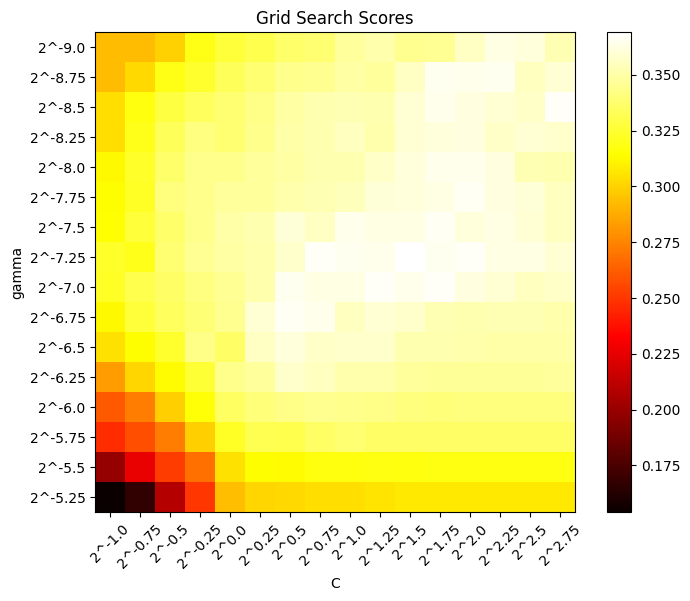

time: 1.24 s (started: 2023-12-15 01:43:42 +00:00)


In [ ]:
print('C:', np.log2(2.8284271247461903))
print('gamma:', np.log2(0.0065695032441696445))
scores = finer_grid_raw.cv_results_['mean_test_score'].reshape(len(C_finer_range),len(gamma_finer_range)).transpose()
plotSVCHeatmap(scores, C_finer_range, gamma_finer_range,)

In [ ]:
est = finer_grid_raw.best_estimator_
est.fit(x_train_flat, y_train)
est.score(x_test_flat, y_test)

[LibSVM]

0.5706

time: 2h 31min 53s (started: 2023-12-16 15:21:13 +00:00)


# PCA
Let's try performing PCA before classifying our data with an SVM.

In [ ]:
# help found here
# https://www.datacamp.com/tutorial/principal-component-analysis-in-python

from sklearn.decomposition import PCA


pca = PCA(0.9) # we want at least 90% of the original data
pca.fit(x_train_flat)

PCA(n_components=0.9)

time: 3min 24s (started: 2023-12-17 13:41:22 +00:00)


In [ ]:
pca.n_components_

99

time: 4.54 ms (started: 2023-12-10 09:49:23 +00:00)


In [ ]:
pca_train = pca.transform(x_train_flat)
pca_test = pca.transform(x_test_flat)

time: 2.53 s (started: 2023-12-17 13:44:47 +00:00)


In [ ]:
C_range = range(-15, 15)
linear_param_grid = {'C': [2 ** x for x in C_range],
                    #  'intercept_scaling': [5],
                     'fit_intercept': [True],
                    #  'loss': ['hinge'],
                     'dual':[False], # false because n_samples >> n_features
                     'verbose': [3]}
est = do_grid_search_linearsvc(linear_param_grid, pca_train, pca_test,
                         y_train, y_test)

[LibLinear]The best accuracy was 0.39061999999999997 for the parameters: {'C': 0.00048828125, 'dual': False, 'fit_intercept': True, 'verbose': 3}
time: 39min 1s (started: 2023-12-12 17:47:44 +00:00)


In [25]:
if False: # save model to Drive?
  with open(prefix+'linear_SVC_PCA.svc', 'wb') as fo:
    pickle.dump(est, fo)

if True: # load model from disk?
  with open(prefix+'linear_SVC_PCA.svc', 'rb') as fo:
    est = pickle.load(fo)
    C_range = range(-15, 15)

time: 470 ms (started: 2023-12-18 19:34:38 +00:00)


The test scores were as follows: [0.38388 0.38762 0.38926 0.39028 0.39062 0.39024 0.39042 0.39022 0.39022
 0.39014 0.39006 0.39012 0.39014 0.39008 0.39008 0.3901  0.3901  0.3901
 0.3901  0.3901  0.3901  0.3901  0.3901  0.3901  0.3901  0.3901  0.3901
 0.3901  0.3901  0.3901 ]


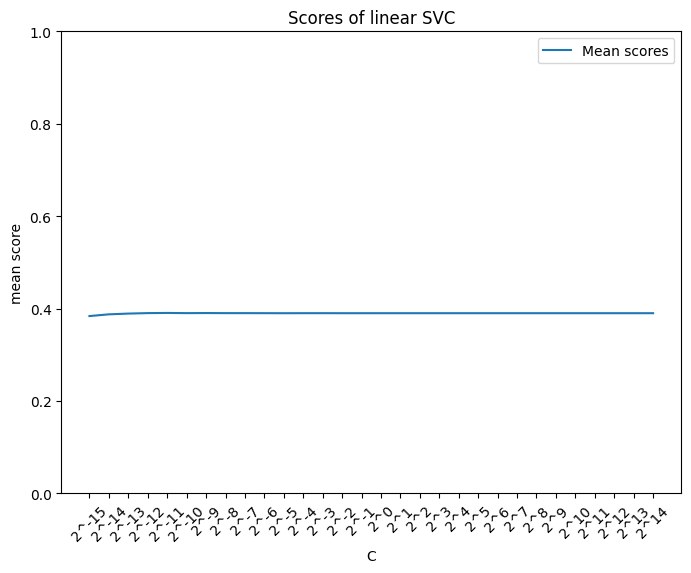

time: 694 ms (started: 2023-12-18 19:34:40 +00:00)


In [26]:
scores = est.cv_results_['mean_test_score']
plotLinearSVCAccuracy(scores, C_range)
print('The test scores were as follows:', scores)

In [ ]:
C = np.log2(0.00048828125) # C = 11 from previous grid search
C_range_finer = np.arange(C-1, C+1, .25)
linear_param_grid = {'C': [2 ** x for x in C_range_finer],
                    #  'intercept_scaling': [5],
                     'fit_intercept': [True],
                    #  'loss': ['hinge'],
                     'dual':[False], # false because n_samples >> n_features
                     'verbose': [3]}
est_finer = do_grid_search_linearsvc(linear_param_grid, pca_train, pca_test,
                         y_train, y_test)

[LibLinear]The best accuracy was 0.39061999999999997 for the parameters: {'C': 0.00048828125, 'dual': False, 'fit_intercept': True, 'verbose': 3}
time: 11min 44s (started: 2023-12-17 13:44:51 +00:00)


The test scores were as follows: [0.39028 0.3905  0.3905  0.39048 0.39062 0.39058 0.3905  0.39048]


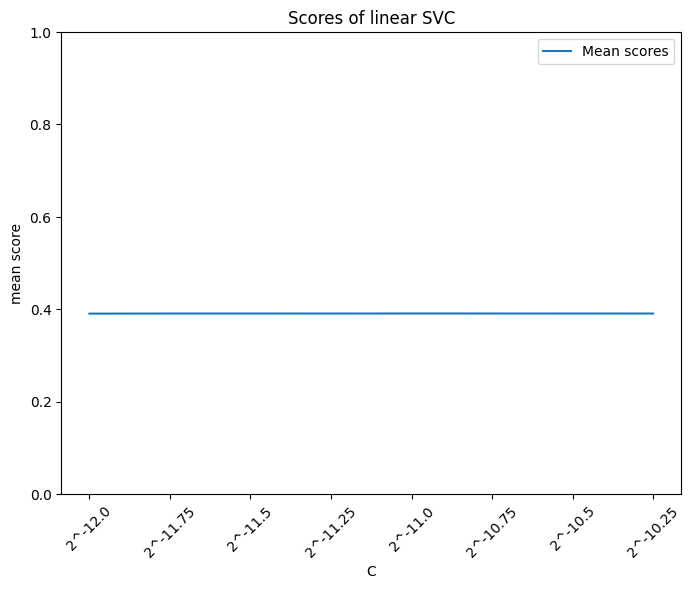

time: 579 ms (started: 2023-12-17 13:56:35 +00:00)


In [ ]:
scores = est_finer.cv_results_['mean_test_score']
plotLinearSVCAccuracy(scores, C_range_finer)
print('The test scores were as follows:', scores)

In [ ]:
est = est_finer.best_estimator_
est.fit(x_train_flat, y_train)
est.score(x_test_flat, y_test)

[LibLinear]

0.4098

time: 10min 9s (started: 2023-12-17 13:56:35 +00:00)
